## `Augmented Reality with Planar Homographies`

`importing libraries`

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

`Load Data`

In [3]:
image_path = os.path.join("..", "material", "cv_cover.jpg")
cv_cover = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [4]:
def convert_to_grayscale(image):
    """Convert a given image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

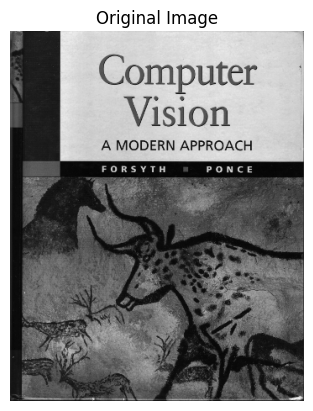

In [5]:
plt.figure()
plt.imshow(cv_cover, cmap='gray')
plt.axis('off')
plt.title("Original Image")


plt.show()

In [6]:
def load_first_frame(video_path):
    # Create a VideoCapture object and read from input file
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError("Could not read the first frame from the video.")
    return frame


def load_video_frames(video_path):  

    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames



In [7]:
# Load the first frame of the video
video1_path = os.path.join("..", "material", "book.mov")
book_first_frame = load_first_frame(video1_path)

# # Convert to grayscale
# if book_first_frame is not None:
#     book_first_frame_gray = convert_to_grayscale(book_first_frame)

#     # Display the grayscale image
#     plt.figure()
#     plt.imshow(book_first_frame_gray, cmap='gray')
#     plt.axis('off')
#     plt.title("Sample from the book video (Grayscale)")
#     plt.show()
# else:
#     print("Error: Could not load the first frame of the book video.")


### 1.1 Getting Correspondences

In [8]:
def get_corresponding_points(image1, image2):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    # Create BFMatcher with L2 norm
    bf = cv2.BFMatcher(normType=cv2.NORM_L2)

    # Find the 2 nearest matches for each descriptor
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Sort matches based on distance
    good_matches = sorted(good_matches, key=lambda x: x.distance)

    # Keep only top 50
    top_matches = good_matches[:50]

    return keypoints1, keypoints2, top_matches


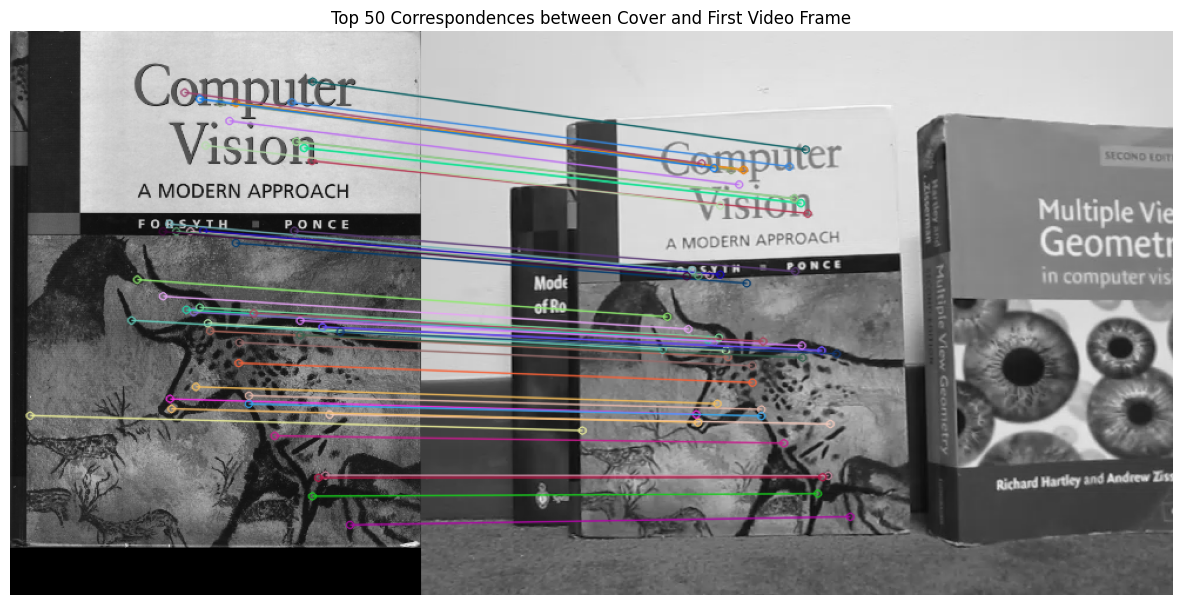

In [9]:
if book_first_frame is not None:
    book_first_frame_gray = convert_to_grayscale(book_first_frame)

    # Get top 50 correspondences
    kp1, kp2, matches = get_corresponding_points(cv_cover, book_first_frame_gray)

    # Draw the matches
    img_matches = cv2.drawMatches(
        cv_cover, kp1,
        book_first_frame_gray, kp2,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Display the matches using matplotlib
    plt.figure(figsize=(15, 8))
    plt.imshow(img_matches)
    plt.axis('off')
    plt.title("Top 50 Correspondences between Cover and First Video Frame")
    plt.show()

else:
    print("Error: Could not load the first frame of the book video.")

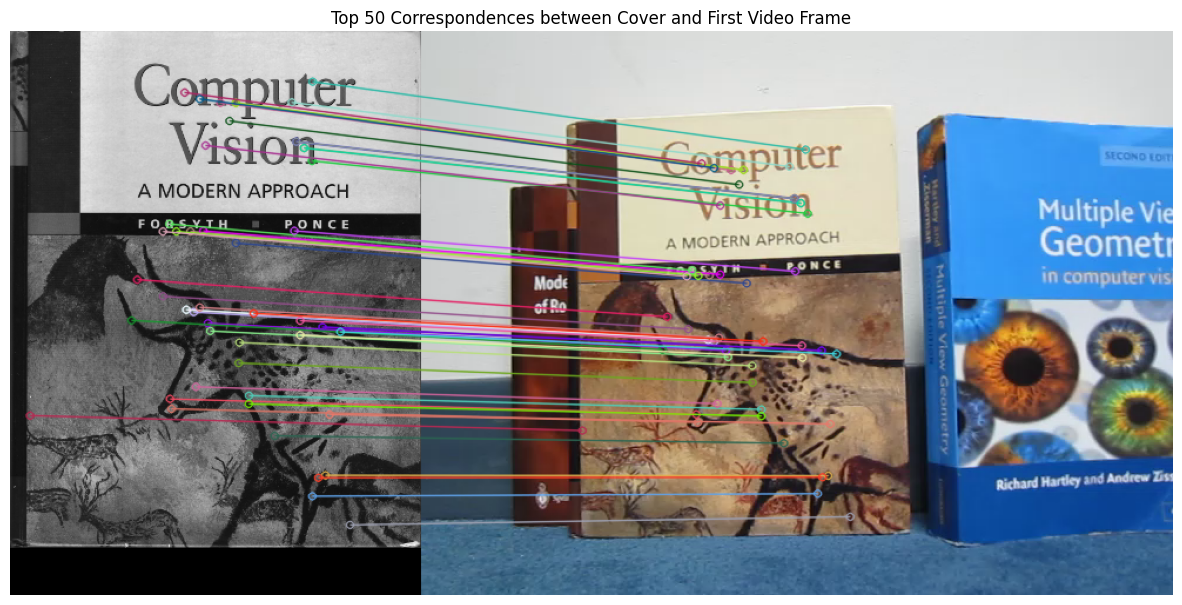

In [10]:
if book_first_frame is not None:
    # Convert the first frame to grayscale for comparison
    book_first_frame_gray = convert_to_grayscale(book_first_frame)

    # Get top 50 correspondences
    kp1, kp2, matches = get_corresponding_points(cv_cover, book_first_frame_gray)

    # Draw the matches
    img_matches = cv2.drawMatches(
        cv_cover, kp1,
        book_first_frame, kp2,  # Use the original colored frame for drawing
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Convert the image from BGR to RGB for proper display in matplotlib
    img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

    # Display the matches using matplotlib
    plt.figure(figsize=(15, 8))
    plt.imshow(img_matches_rgb)
    plt.axis('off')
    plt.title("Top 50 Correspondences between Cover and First Video Frame")
    plt.show()

else:
    print("Error: Could not load the first frame of the book video.")



### 1.2  Compute the Homography Parameters

In [11]:
def compute_homography_dlt(src_pts, dst_pts):
    """Compute the homography matrix using DLT algorithm."""
    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i][0], src_pts[i][1]
        u, v = dst_pts[i][0], dst_pts[i][1]
        A.append([-x, -y, -1, 0, 0, 0, u*x, u*y, u])
        A.append([0, 0, 0, -x, -y, -1, v*x, v*y, v])
    A = np.array(A)
    
    # Perform SVD
    _, _, Vt = np.linalg.svd(A)
    
    # Homography is the last column of V
    H = Vt[-1].reshape(3, 3)
    # Normalize the homography matrix
    H /= H[2, 2]
    
    return H

In [12]:
# def ransac(src_pts, dst_pts, threshold=5.0,num_iterations=100):
#     """Compute the homography matrix using RANSAC algorithm."""
#     best_inliers_count = 0
#     best_H = None
#     n_points = len(src_pts)

#     for _ in range(num_iterations):
#         # Randomly select 4 points
#         indices = np.random.choice(n_points, 4, replace=False)
#         sampled_src = src_pts[indices]
#         sampled_dst = dst_pts[indices]

#         # Compute homography using DLT
#         H = compute_homography_dlt(sampled_src, sampled_dst)

#         # Project points from source to destination
#         src_pts_homogeneous = np.hstack((src_pts, np.ones((n_points, 1))))
#         projected_pts = H @ src_pts_homogeneous.T
#         projected_pts /= projected_pts[2, :]

#         # Compute distances
#         distances = np.linalg.norm(dst_pts - projected_pts[:2].T, axis=1) # heterogeneous coordinates

#         # Count inliers
#         inliers_count = np.sum(distances < threshold)

#         # Update best homography if current one has more inliers
#         if inliers_count > best_inliers_count:
#             best_inliers_count = inliers_count
#             best_H = H

#     return best_H

In [13]:
def ransac(src_pts, dst_pts, threshold=5.0, num_iterations=1000, early_stopping=True):
    """Robust homography estimation using RANSAC.
    
    Args:
        src_pts: Source points (Nx2 array).
        dst_pts: Destination points (Nx2 array).
        threshold: Inlier threshold in pixels.
        num_iterations: Max RANSAC iterations.
        early_stopping: Stop if >95% inliers found.
        
    Returns:
        best_H: Best homography matrix (3x3).
        inliers: Boolean mask of inliers.
    """
    best_inliers = None
    best_inliers_count = 0
    best_H = None
    n_points = len(src_pts)
    
    for _ in range(num_iterations):
        # 1. Randomly select 4 point pairs
        indices = np.random.choice(n_points, 4, replace=False)
        sampled_src = src_pts[indices]
        sampled_dst = dst_pts[indices]
        
        # 2. Compute homography (DLT)
        H = compute_homography_dlt(sampled_src, sampled_dst)
        if H is None:
            continue
        
        # 3. Project all points using H
        src_h = np.hstack((src_pts, np.ones((n_points, 1))))  # Homogeneous
        projected = (H @ src_h.T).T  # Project (3x3 @ 3xN -> 3xN, then transpose
        projected /= projected[:, 2].reshape(-1, 1)  # Normalize
        
        # 4. Compute reprojection errors
        errors = np.linalg.norm(dst_pts - projected[:, :2], axis=1)
        inliers = errors < threshold
        inliers_count = np.sum(inliers)
        
        # 5. Update best model
        if inliers_count > best_inliers_count:
            best_inliers_count = inliers_count
            best_inliers = inliers
            best_H = H
            
            # Early termination (optional)
            if early_stopping and inliers_count >= 0.95 * n_points:
                break
    
    # 6. Refit H using all inliers (if any found)
    if best_inliers_count >= 4:  # Minimum 4 points
        best_H = compute_homography_dlt(
            src_pts[best_inliers], 
            dst_pts[best_inliers]
        )
    
    return best_H, best_inliers


In [14]:
# Extract corresponding points from the matches
P = np.array([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
P_dash = np.array([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

# Compute Homography using RANSAC
H, mask = ransac(P, P_dash)

# Recompute H using all inliers
H = compute_homography_dlt(P[mask], P_dash[mask])
print("H using our function:")
print(H)

# Check H using the built-in function
H_built_in, _ = cv2.findHomography(P, P_dash, cv2.RANSAC)
print("H using built-in function:")
print(H_built_in)


H using our function:
[[ 7.73175741e-01  2.75722138e-03  1.19569964e+02]
 [-5.11103701e-02  7.78602149e-01  7.74981421e+01]
 [-9.11956235e-05 -7.43420663e-05  1.00000000e+00]]
H using built-in function:
[[ 7.73918433e-01  2.98716605e-03  1.19494352e+02]
 [-5.06993013e-02  7.79124943e-01  7.74114010e+01]
 [-8.98341594e-05 -7.36718754e-05  1.00000000e+00]]


### 1.3  Calculate Book Coordinates

In [15]:
# Get the four corners of the book cover image
h, w = cv_cover.shape
book_corners = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype='float32').reshape(-1, 1, 2)

# Apply the homography to the book corners
book_corners_transformed = cv2.perspectiveTransform(book_corners, H)

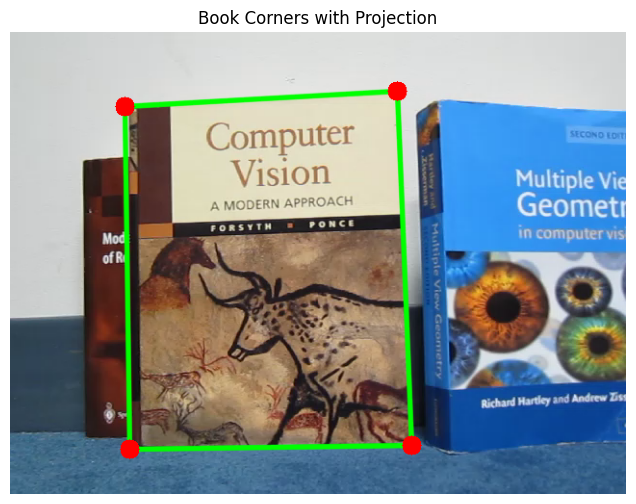

In [16]:
# Assuming you already have the homography matrix H and the book video frames

# Draw the projected rectangle on a copy of the first frame
img_with_lines = cv2.polylines(book_first_frame.copy(), [np.int32(book_corners_transformed)],
                               isClosed=True, color=(0, 255, 0), thickness=3, lineType=cv2.LINE_AA)

# Draw red circles at each projected corner
for corner in book_corners_transformed:
    x, y = corner[0]
    cv2.circle(img_with_lines, (int(x), int(y)), 10, (0, 0, 255), -1)

# Convert BGR image (OpenCV default) to RGB 
# for display with matplotlib
img_rgb = cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB)

# Display using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.title("Book Corners with Projection")
plt.axis("off")
plt.show()